<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Dual_Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR", "Dual Memory ICMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
# Parameters
data_path = "data/HowardKahana2005.csv"
trial_query = "subject > -1"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_1_0_0", "ICMR_1_0_1", "ICMR_1_1_0", "ICMR_1_1_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]
section_tag = "HowardKahana2005"


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function lohnas_objective_function.<locals>.objective_function at 0x2aecc2a724c0>


934.6436132679794
1671.6771065173234


<function lohnas_objective_function.<locals>.objective_function at 0x2aecc35419d0>


934.6436132679794
1671.6771065173234
<function lohnas_objective_function.<locals>.objective_function at 0x2aecc47664c0>


934.6436132679794
1671.6771065173234
<function lohnas_objective_function.<locals>.objective_function at 0x2aecc42e6040>


934.6436132679794
1671.6771065173234
<function lohnas_objective_function.<locals>.objective_function at 0x2aecc4e2d4c0>


934.6436132679794
1671.6771065173234
dependencies and parameters validated


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag HowardKahana2005 already exist
ICMR_1_0_0, Subject 118


407.80049499358677
ICMR_1_0_0, Subject 119


417.980753122645
ICMR_1_0_0, Subject 123


526.8587253552672
ICMR_1_0_0, Subject 124


561.205906272835
ICMR_1_0_0, Subject 125


644.1392020429746
ICMR_1_0_0, Subject 126


791.1779996093668
ICMR_1_0_0, Subject 128


457.02683117451824
ICMR_1_0_0, Subject 129


428.4520901557764
ICMR_1_0_0, Subject 130


553.501671784149
ICMR_1_0_0, Subject 131


304.34480650603626
ICMR_1_0_0, Subject 132


423.2955429049795
ICMR_1_0_0, Subject 133


552.9627358210358
ICMR_1_0_0, Subject 134


471.0296840327305
ICMR_1_0_0, Subject 135


276.3113823706968
ICMR_1_0_0, Subject 136


809.8886327099058
ICMR_1_0_0, Subject 137


516.8785234435763
ICMR_1_0_0, Subject 138


234.97594521889607
ICMR_1_0_0, Subject 139


463.63257378572945
ICMR_1_0_0, Subject 140


427.95076112804026
ICMR_1_0_0, Subject 141


237.98878196499723
ICMR_1_0_0, Subject 142


342.87113485541954
ICMR_1_0_0, Subject 144


281.81363643202
ICMR_1_0_0, Subject 145


287.83179443413826
ICMR_1_0_0, Subject 146


407.10252906841777
ICMR_1_0_0, Subject 147


550.9249107305666
ICMR_1_0_0, Subject 148


377.79837083797224
ICMR_1_0_0, Subject 149


567.9707901067758
ICMR_1_0_0, Subject 150


461.97135167762497
ICMR_1_0_0, Subject 151


352.202060884789
ICMR_1_0_0, Subject 152


413.8578558048309
ICMR_1_0_0, Subject 153


408.49703766251565
ICMR_1_0_0, Subject 154


605.3999356178001
ICMR_1_0_0, Subject 155


340.5728157310354
ICMR_1_0_0, Subject 156


626.832747928933
ICMR_1_0_0, Subject 157


465.46274216869665
ICMR_1_0_0, Subject 158


530.4846399263437
ICMR_1_0_0, Subject 159


692.7907962505726
ICMR_1_0_0, Subject 160


501.06251541463814
ICMR_1_0_0, Subject 161


339.1180434460448
ICMR_1_0_0, Subject 162


360.46978013869415
ICMR_1_0_0, Subject 163


446.2597989405526
ICMR_1_0_0, Subject 164


493.10298622161844
ICMR_1_0_0, Subject 165


627.7830922811816
ICMR_1_0_0, Subject 166


396.61360055706115
ICMR_1_0_0, Subject 167


731.7287553979238
ICMR_1_0_0, Subject 168


342.34844640438325
ICMR_1_0_0, Subject 169


532.1597797436476
ICMR_1_0_0, Subject 170


245.47047979030316
ICMR_1_0_0, Subject 171


380.08628220583154
ICMR_1_0_0, Subject 172


497.07559132850685
ICMR_1_0_0, Subject 173


206.6488697644197
ICMR_1_0_0, Subject 174


628.6077709934451
ICMR_1_0_0, Subject 175


558.367020249146
ICMR_1_0_0, Subject 176


430.1561858009646
ICMR_1_0_0, Subject 177


447.13616309172767
ICMR_1_0_0, Subject 178


325.41136631318227
ICMR_1_0_0, Subject 179


555.1046559073316
ICMR_1_0_0, Subject 180


547.4365318331846
ICMR_1_0_0, Subject 300


520.4344934681601
ICMR_1_0_0, Subject 301


383.77804995679014
ICMR_1_0_0, Subject 302


520.8449739406611
ICMR_1_0_0, Subject 311


568.0120777747825
ICMR_1_0_0, Subject 312


520.0849026200502
ICMR_1_0_0, Subject 313


705.6413725252412
ICMR_1_0_0, Subject 314


602.1082900779146
ICMR_1_0_0, Subject 315


647.8669445297952


ICMR_1_0_1, Subject 118


408.1409214956536
ICMR_1_0_1, Subject 119


418.24850153176527
ICMR_1_0_1, Subject 123


527.0013037403882
ICMR_1_0_1, Subject 124


556.3042944328349
ICMR_1_0_1, Subject 125


640.174999343002
ICMR_1_0_1, Subject 126


790.7550017231878
ICMR_1_0_1, Subject 128


456.987844697753
ICMR_1_0_1, Subject 129


433.8458951187821
ICMR_1_0_1, Subject 130


553.4673267139473
ICMR_1_0_1, Subject 131


305.262988269316
ICMR_1_0_1, Subject 132


410.85815907390037
ICMR_1_0_1, Subject 133


552.4411465453029
ICMR_1_0_1, Subject 134


452.3313298126705
ICMR_1_0_1, Subject 135


281.32439786829684
ICMR_1_0_1, Subject 136


809.8104346478407
ICMR_1_0_1, Subject 137


516.0155457403025
ICMR_1_0_1, Subject 138


234.1163063016474
ICMR_1_0_1, Subject 139


462.9252023536729
ICMR_1_0_1, Subject 140


427.6369166055667
ICMR_1_0_1, Subject 141


236.93018245471114
ICMR_1_0_1, Subject 142


341.44967956179545
ICMR_1_0_1, Subject 144


281.7917643697136
ICMR_1_0_1, Subject 145


282.3165415890865
ICMR_1_0_1, Subject 146


407.0594140279538
ICMR_1_0_1, Subject 147


550.9854086024882
ICMR_1_0_1, Subject 148


374.5920725362848
ICMR_1_0_1, Subject 149


567.7642829730484
ICMR_1_0_1, Subject 150


461.97328896679034
ICMR_1_0_1, Subject 151


352.1616518235615
ICMR_1_0_1, Subject 152


420.10978085319243
ICMR_1_0_1, Subject 153


409.1048133521626
ICMR_1_0_1, Subject 154


605.3700912150659
ICMR_1_0_1, Subject 155


341.2671416224987
ICMR_1_0_1, Subject 156


632.8837279483298
ICMR_1_0_1, Subject 157


469.82947071082776
ICMR_1_0_1, Subject 158


529.818475871456
ICMR_1_0_1, Subject 159


706.6302118520287
ICMR_1_0_1, Subject 160


494.8167624602502
ICMR_1_0_1, Subject 161


340.7117023338594
ICMR_1_0_1, Subject 162


360.47731930122467
ICMR_1_0_1, Subject 163


446.3490240861846
ICMR_1_0_1, Subject 164


494.0859509650884
ICMR_1_0_1, Subject 165


627.1296596819527
ICMR_1_0_1, Subject 166


393.6319621253031
ICMR_1_0_1, Subject 167


731.3916358419744
ICMR_1_0_1, Subject 168


344.8506133399764
ICMR_1_0_1, Subject 169


512.3884034880352
ICMR_1_0_1, Subject 170


242.96930610475488
ICMR_1_0_1, Subject 171


380.14078499192124
ICMR_1_0_1, Subject 172


476.87470021227006
ICMR_1_0_1, Subject 173


206.6827964332843
ICMR_1_0_1, Subject 174


629.4653531938255
ICMR_1_0_1, Subject 175


556.5173637144766
ICMR_1_0_1, Subject 176


414.5753357394186
ICMR_1_0_1, Subject 177


447.8490621928413
ICMR_1_0_1, Subject 178


325.4201420945098
ICMR_1_0_1, Subject 179


545.5487885468242
ICMR_1_0_1, Subject 180


546.5060623324898
ICMR_1_0_1, Subject 300


520.3864354315973
ICMR_1_0_1, Subject 301


383.84607943086377
ICMR_1_0_1, Subject 302


520.6114134803656
ICMR_1_0_1, Subject 311


568.4756782990847
ICMR_1_0_1, Subject 312


520.8961820375157
ICMR_1_0_1, Subject 313


704.1807362024232
ICMR_1_0_1, Subject 314


602.6952955236043
ICMR_1_0_1, Subject 315


647.8163033249327


ICMR_1_1_0, Subject 118


407.855835412533
ICMR_1_1_0, Subject 119


414.0063939021072
ICMR_1_1_0, Subject 123


527.7810677550387
ICMR_1_1_0, Subject 124


559.1378544874481
ICMR_1_1_0, Subject 125


640.3069496249693
ICMR_1_1_0, Subject 126


791.8694250154679
ICMR_1_1_0, Subject 128


457.3626535426466
ICMR_1_1_0, Subject 129


433.68403579976933
ICMR_1_1_0, Subject 130


554.1323955240823
ICMR_1_1_0, Subject 131


306.8360120013304
ICMR_1_1_0, Subject 132


411.3307643327583
ICMR_1_1_0, Subject 133


551.7849563502813
ICMR_1_1_0, Subject 134


456.69927349617006
ICMR_1_1_0, Subject 135


280.4084887526384
ICMR_1_1_0, Subject 136


809.4512962778209
ICMR_1_1_0, Subject 137


515.9978884800055
ICMR_1_1_0, Subject 138


237.31579373997963
ICMR_1_1_0, Subject 139


464.187288309462
ICMR_1_1_0, Subject 140


427.7737470774623
ICMR_1_1_0, Subject 141


237.3256774139216
ICMR_1_1_0, Subject 142


340.3021058524267
ICMR_1_1_0, Subject 144


282.2861423931974
ICMR_1_1_0, Subject 145


281.0585056561978
ICMR_1_1_0, Subject 146


407.0617649108488
ICMR_1_1_0, Subject 147


550.9610233791437
ICMR_1_1_0, Subject 148


374.7267802203509
ICMR_1_1_0, Subject 149


567.8010452123438
ICMR_1_1_0, Subject 150


460.88422214139206
ICMR_1_1_0, Subject 151


346.3302629028112
ICMR_1_1_0, Subject 152


425.76005885320507
ICMR_1_1_0, Subject 153


409.83400017331905
ICMR_1_1_0, Subject 154


606.0136068173869
ICMR_1_1_0, Subject 155


343.0698477479022
ICMR_1_1_0, Subject 156


627.1737953614343
ICMR_1_1_0, Subject 157


460.770074951317
ICMR_1_1_0, Subject 158


527.6657467460091
ICMR_1_1_0, Subject 159


695.4768223839155
ICMR_1_1_0, Subject 160


495.2807081588413
ICMR_1_1_0, Subject 161


339.19865658201303
ICMR_1_1_0, Subject 162


360.69479591349136
ICMR_1_1_0, Subject 163


445.40139541771293
ICMR_1_1_0, Subject 164


493.1168127080842
ICMR_1_1_0, Subject 165


627.5077118569908
ICMR_1_1_0, Subject 166


395.28267797677745
ICMR_1_1_0, Subject 167


730.640743023861
ICMR_1_1_0, Subject 168


343.5219328444453
ICMR_1_1_0, Subject 169


507.34943800657464
ICMR_1_1_0, Subject 170


245.54604554521825
ICMR_1_1_0, Subject 171


387.27641677663115
ICMR_1_1_0, Subject 172


477.88351091045223
ICMR_1_1_0, Subject 173


206.87202735430944
ICMR_1_1_0, Subject 174


628.3437773944366
ICMR_1_1_0, Subject 175


557.415610645669
ICMR_1_1_0, Subject 176


417.66025776677276
ICMR_1_1_0, Subject 177


439.2679151617877
ICMR_1_1_0, Subject 178


325.6720638391583
ICMR_1_1_0, Subject 179


546.1104413539763
ICMR_1_1_0, Subject 180


546.9086377243922
ICMR_1_1_0, Subject 300


559.2651329922801
ICMR_1_1_0, Subject 301


385.82013009053384
ICMR_1_1_0, Subject 302


520.3743978805246
ICMR_1_1_0, Subject 311


567.5607611093287
ICMR_1_1_0, Subject 312


570.9407609324843
ICMR_1_1_0, Subject 313


704.7467286971828
ICMR_1_1_0, Subject 314


601.9046286801512
ICMR_1_1_0, Subject 315


649.2738347128279
ICMR_1_1_1, Subject 118


416.159279199981
ICMR_1_1_1, Subject 119


418.0016734992613
ICMR_1_1_1, Subject 123


528.2223638272897
ICMR_1_1_1, Subject 124


564.2179759906343
ICMR_1_1_1, Subject 125


646.6180846061226
ICMR_1_1_1, Subject 126


794.559414303526
ICMR_1_1_1, Subject 128


457.301968674889
ICMR_1_1_1, Subject 129


429.92225963594245
ICMR_1_1_1, Subject 130


555.4800981211224
ICMR_1_1_1, Subject 131


306.14463567549194
ICMR_1_1_1, Subject 132


421.7836360164606
ICMR_1_1_1, Subject 133


552.6908236516698
ICMR_1_1_1, Subject 134


460.29539472292197
ICMR_1_1_1, Subject 135


279.82413444069766
ICMR_1_1_1, Subject 136


816.6068665763001
ICMR_1_1_1, Subject 137


517.4461863666563
ICMR_1_1_1, Subject 138


236.9635773167603
ICMR_1_1_1, Subject 139


463.6591307151345
ICMR_1_1_1, Subject 140


427.852119671777
ICMR_1_1_1, Subject 141


236.47277898572597
ICMR_1_1_1, Subject 142


340.043357766794
ICMR_1_1_1, Subject 144


282.48627550721216
ICMR_1_1_1, Subject 145


280.75191796045283
ICMR_1_1_1, Subject 146


407.27067276497604
ICMR_1_1_1, Subject 147


555.0033200726645
ICMR_1_1_1, Subject 148


376.49395050196415
ICMR_1_1_1, Subject 149


571.5811854106387
ICMR_1_1_1, Subject 150


462.42909445456144
ICMR_1_1_1, Subject 151


345.74031643065354
ICMR_1_1_1, Subject 152


424.0855800672844
ICMR_1_1_1, Subject 153


416.0893131082991
ICMR_1_1_1, Subject 154


610.1885609416579
ICMR_1_1_1, Subject 155


349.1533116169663
ICMR_1_1_1, Subject 156


632.8657209148101
ICMR_1_1_1, Subject 157


468.0745447674929
ICMR_1_1_1, Subject 158


529.9047723617737
ICMR_1_1_1, Subject 159


696.8156170026527
ICMR_1_1_1, Subject 160


495.27271379181894
ICMR_1_1_1, Subject 161


344.82813698397945
ICMR_1_1_1, Subject 162


361.29932615877976
ICMR_1_1_1, Subject 163


451.306631279849
ICMR_1_1_1, Subject 164


494.9814344263423
ICMR_1_1_1, Subject 165


630.2581934050619
ICMR_1_1_1, Subject 166


393.39810999177206
ICMR_1_1_1, Subject 167


735.7928870300304
ICMR_1_1_1, Subject 168


343.2273479032214
ICMR_1_1_1, Subject 169


507.8066535749187
ICMR_1_1_1, Subject 170


243.14709682479662
ICMR_1_1_1, Subject 171


380.5497556321135
ICMR_1_1_1, Subject 172


475.9894096287778
ICMR_1_1_1, Subject 173


206.4483383006344
ICMR_1_1_1, Subject 174


628.1770318102859
ICMR_1_1_1, Subject 175


562.3020915479767
ICMR_1_1_1, Subject 176


416.0958805621389
ICMR_1_1_1, Subject 177


449.29099613496
ICMR_1_1_1, Subject 178


326.5179584759816
ICMR_1_1_1, Subject 179


546.6541224536213
ICMR_1_1_1, Subject 180


551.726762855905
ICMR_1_1_1, Subject 300


521.1089512280329
ICMR_1_1_1, Subject 301


386.4785799463022
ICMR_1_1_1, Subject 302


521.5710273542196
ICMR_1_1_1, Subject 311


569.9901176677047
ICMR_1_1_1, Subject 312


519.9896796215426
ICMR_1_1_1, Subject 313


704.2320421696344
ICMR_1_1_1, Subject 314


601.5423759855272
ICMR_1_1_1, Subject 315


647.6865063856377


Text(7.694444444444452, 0.5, 'Individual Log-Likelihood')

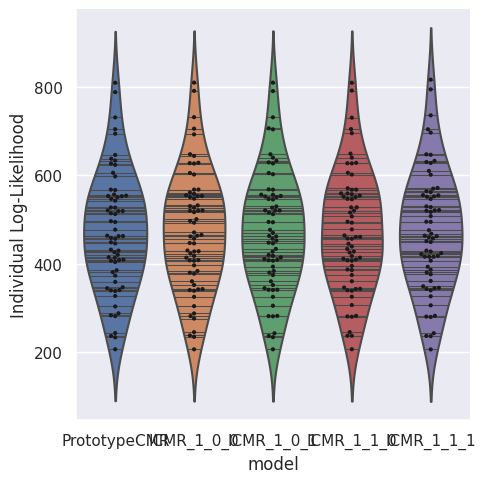

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learn_first
0,118,15,408.493921,PrototypeCMR,0.773425,8.106380e-02,0.805708,0.566366,0.394933,0.048660,75.452367,76.360527,0.014882,0.323659,1.543029,8.714132e-01,NaN,NaN,NaN
1,119,15,420.397833,PrototypeCMR,0.798094,2.344377e-01,0.955422,0.153314,0.385658,0.064229,39.263185,65.392654,0.017354,0.285520,0.827222,2.220446e-16,NaN,NaN,NaN
2,123,15,527.199311,PrototypeCMR,0.705324,9.613934e-01,0.816350,1.000000,0.681998,0.206179,0.737829,23.919264,0.005889,0.284650,4.387943,1.892864e-01,NaN,NaN,NaN
3,124,15,552.951141,PrototypeCMR,0.766899,6.080748e-01,0.942632,1.000000,0.007085,0.042572,3.122382,0.214323,0.006488,0.225401,4.121580,2.220446e-16,NaN,NaN,NaN
4,125,15,637.687439,PrototypeCMR,0.692597,9.757265e-01,0.825899,0.236578,0.268286,0.106166,0.196345,43.469070,0.000109,0.298663,3.393420,9.975219e-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325,311,15,569.990118,ICMR_1_1_1,0.565905,7.236263e-02,0.922485,0.019091,1.000000,0.123508,81.093668,9.477865,0.002380,0.352798,1.000000,2.220446e-16,1.0,2.082684,True
326,312,15,519.989680,ICMR_1_1_1,0.777734,2.327604e-02,0.697959,0.013323,0.873893,0.268165,91.625399,49.267530,0.003844,0.341857,1.000000,3.296486e-10,1.0,2.067349,True
327,313,15,704.232042,ICMR_1_1_1,0.781095,2.220446e-16,0.772700,0.017398,1.000000,0.273942,82.205408,7.141106,0.001846,0.283374,1.000000,2.220446e-16,1.0,2.071669,True
328,314,15,601.542376,ICMR_1_1_1,0.738305,2.220446e-16,0.870883,0.005121,0.689808,0.183095,21.364271,60.562895,0.001220,0.372721,1.000000,4.140668e-01,1.0,1.383889,True


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-HowardKahana2005fits layout-nrow=2 layout-valign="center"}

![](results/individual_HowardKahana2005.pdf)

|       |   ICMR_1_0_0 |   ICMR_1_0_1 |   ICMR_1_1_0 |   ICMR_1_1_1 |   PrototypeCMR |
|:------|-------------:|-------------:|-------------:|-------------:|---------------:|
| count |       66     |       66     |       66     |       66     |         66     |
| mean  |      473.98  |      472.681 |      473.777 |      474.195 |        472.476 |
| std   |      135.108 |      135.354 |      135.545 |      135.777 |        134.402 |
| min   |      206.649 |      206.683 |      206.872 |      206.448 |        206.793 |
| 25%   |      381.009 |      381.067 |      386.184 |      382.032 |        382.277 |
| 50%   |      464.548 |      462.449 |      460.827 |      463.044 |        462.714 |
| 75%   |      554.704 |      553.211 |      558.707 |      555.361 |        553.34  |
| max   |      809.889 |      809.81  |      809.451 |      816.607 |        809.442 |

Distribution 

In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_1_0_0')
Ttest_relResult(statistic=-2.3980133189181423, pvalue=0.01936500843071457)
Ttest_relResult(statistic=-2.3980133189181423, pvalue=0.009682504215357286)
Ttest_relResult(statistic=-2.3980133189181423, pvalue=0.9903174957846427)

('PrototypeCMR', 'ICMR_1_0_1')
Ttest_relResult(statistic=-0.4310974597391962, pvalue=0.6678238534941106)
Ttest_relResult(statistic=-0.4310974597391962, pvalue=0.3339119267470553)
Ttest_relResult(statistic=-0.4310974597391962, pvalue=0.6660880732529448)

('PrototypeCMR', 'ICMR_1_1_0')
Ttest_relResult(statistic=-1.201483216757468, pvalue=0.23392332608942898)
Ttest_relResult(statistic=-1.201483216757468, pvalue=0.11696166304471449)
Ttest_relResult(statistic=-1.201483216757468, pvalue=0.8830383369552854)

('PrototypeCMR', 'ICMR_1_1_1')
Ttest_relResult(statistic=-3.34891178932391, pvalue=0.001353521346330422)
Ttest_relResult(statistic=-3.34891178932391, pvalue=0.000676760673165211)
Ttest_relResult(statistic=-3.34891178932391, pvalue=0.999

In [9]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_1_0_0')
0.6060606060606061 0.3939393939393939
40 26

('PrototypeCMR', 'ICMR_1_0_1')
0.48484848484848486 0.5151515151515151
32 34

('PrototypeCMR', 'ICMR_1_1_0')
0.6515151515151515 0.3484848484848485
43 23

('PrototypeCMR', 'ICMR_1_1_1')
0.6515151515151515 0.3484848484848485
43 23

('ICMR_1_0_0', 'ICMR_1_0_1')
0.42424242424242425 0.5757575757575758
28 38

('ICMR_1_0_0', 'ICMR_1_1_0')
0.45454545454545453 0.5454545454545454
30 36

('ICMR_1_0_0', 'ICMR_1_1_1')
0.6515151515151515 0.3484848484848485
43 23

('ICMR_1_0_1', 'ICMR_1_1_0')
0.5909090909090909 0.4090909090909091
39 27

('ICMR_1_0_1', 'ICMR_1_1_1')
0.7121212121212122 0.2878787878787879
47 19

('ICMR_1_1_0', 'ICMR_1_1_1')
0.6212121212121212 0.3787878787878788
41 25



In [10]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[9.99998723e-01 7.48819771e-44 1.27728992e-06 5.17209465e-38
 5.28980378e-50]


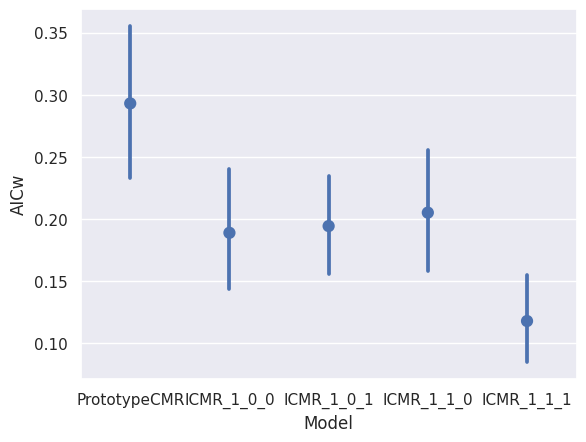

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                #model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df_from_events(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")

NameError: name 'simulate_df_from_events' is not defined